# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

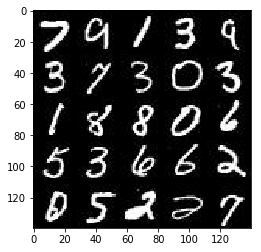

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

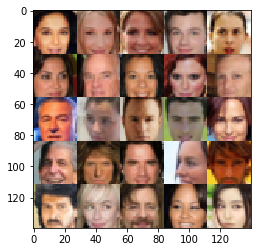

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, 
                        (None, image_width, image_height, image_channels),
                        name='input_real')
    inputs_z = tf.placeholder(tf.float32,
                        (None, z_dim),
                        name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1) # activation=None
        out = tf.sigmoid(logits)        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 3*3*512)
        
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3
        
        out = tf.tanh(logits)
        
        return out
    
#     return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
#     saver = tf.train.Saver()

    input_real, input_z, learning_rate_tensor = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_tensor, beta1)
    
    steps = 0
    print_every = 20
    show_every = 400

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2 ###
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     learning_rate_tensor: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     input_real: batch_images, #
                                                     learning_rate_tensor: learning_rate})
            
                if steps % print_every == 0:
                    # Get losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, 
                                                     input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

            
#             sample_z = np.random_uniform(-1, 1, size=(25, z_dim))
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.4538
Epoch 1/2... Discriminator Loss: 0.1295... Generator Loss: 3.0333
Epoch 1/2... Discriminator Loss: 0.0791... Generator Loss: 4.3272
Epoch 1/2... Discriminator Loss: 0.3653... Generator Loss: 7.3768
Epoch 1/2... Discriminator Loss: 0.0840... Generator Loss: 2.9177
Epoch 1/2... Discriminator Loss: 0.2063... Generator Loss: 2.0175
Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 0.6446
Epoch 1/2... Discriminator Loss: 0.2355... Generator Loss: 2.3486
Epoch 1/2... Discriminator Loss: 0.0963... Generator Loss: 3.2782
Epoch 1/2... Discriminator Loss: 0.0585... Generator Loss: 5.0116
Epoch 1/2... Discriminator Loss: 0.2237... Generator Loss: 2.6343
Epoch 1/2... Discriminator Loss: 0.2472... Generator Loss: 1.8599
Epoch 1/2... Discriminator Loss: 0.0988... Generator Loss: 3.3594
Epoch 1/2... Discriminator Loss: 0.1274... Generator Loss: 3.4157
Epoch 1/2... Discriminator Loss: 0.0585... Generator Loss: 4.0060
Epoch 1/2.

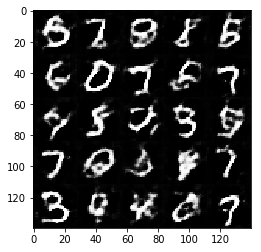

Epoch 2/2... Discriminator Loss: 0.7170... Generator Loss: 1.5767
Epoch 2/2... Discriminator Loss: 0.7760... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 0.7803... Generator Loss: 1.8628
Epoch 2/2... Discriminator Loss: 0.6917... Generator Loss: 0.9442
Epoch 2/2... Discriminator Loss: 0.6484... Generator Loss: 1.7977
Epoch 2/2... Discriminator Loss: 0.8617... Generator Loss: 0.7852
Epoch 2/2... Discriminator Loss: 0.8262... Generator Loss: 0.9497
Epoch 2/2... Discriminator Loss: 0.6144... Generator Loss: 1.7397
Epoch 2/2... Discriminator Loss: 1.4746... Generator Loss: 0.4043
Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.1016
Epoch 2/2... Discriminator Loss: 1.0163... Generator Loss: 0.6473
Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 0.9279
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 1.8370
Epoch 2/2... Discriminator Loss: 0.9533... Generator Loss: 0.6679
Epoch 2/2.

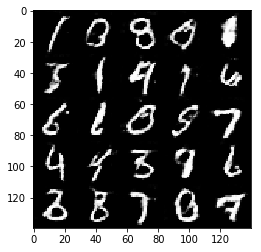

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 0.5395... Generator Loss: 8.2230
Epoch 1/2... Discriminator Loss: 0.1063... Generator Loss: 4.1733
Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 0.7059... Generator Loss: 1.1844
Epoch 1/2... Discriminator Loss: 0.1631... Generator Loss: 3.9877
Epoch 1/2... Discriminator Loss: 0.1189... Generator Loss: 2.8206
Epoch 1/2... Discriminator Loss: 0.1127... Generator Loss: 2.5774
Epoch 1/2... Discriminator Loss: 0.2051... Generator Loss: 3.0643
Epoch 1/2... Discriminator Loss: 0.1603... Generator Loss: 2.3984
Epoch 1/2... Discriminator Loss: 0.8369... Generator Loss: 0.6623
Epoch 1/2... Discriminator Loss: 0.2866... Generator Loss: 1.9841
Epoch 1/2... Discriminator Loss: 0.1195... Generator Loss: 3.0022
Epoch 1/2... Discriminator Loss: 0.3049... Generator Loss: 2.4023
Epoch 1/2... Discriminator Loss: 0.0505... Generator Loss: 4.2404
Epoch 1/2.

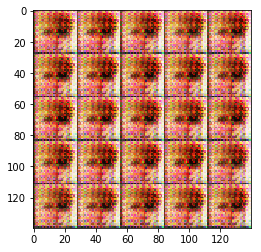

Epoch 1/2... Discriminator Loss: 0.0347... Generator Loss: 3.6215
Epoch 1/2... Discriminator Loss: 0.0535... Generator Loss: 3.5131
Epoch 1/2... Discriminator Loss: 0.1194... Generator Loss: 3.4212
Epoch 1/2... Discriminator Loss: 0.1164... Generator Loss: 2.7029
Epoch 1/2... Discriminator Loss: 0.0125... Generator Loss: 5.3254
Epoch 1/2... Discriminator Loss: 0.0394... Generator Loss: 3.6719
Epoch 1/2... Discriminator Loss: 0.0742... Generator Loss: 3.4590
Epoch 1/2... Discriminator Loss: 0.1558... Generator Loss: 2.8742
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 0.6859
Epoch 1/2... Discriminator Loss: 1.1830... Generator Loss: 0.6001
Epoch 1/2... Discriminator Loss: 0.5055... Generator Loss: 2.0197
Epoch 1/2... Discriminator Loss: 0.5825... Generator Loss: 2.8674
Epoch 1/2... Discriminator Loss: 0.2487... Generator Loss: 2.2806
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 5.8340
Epoch 1/2... Discriminator Loss: 0.5677... Generator Loss: 1.3824
Epoch 1/2.

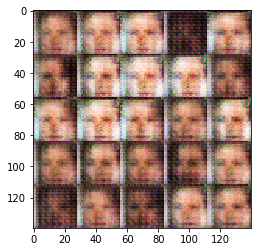

Epoch 1/2... Discriminator Loss: 0.3405... Generator Loss: 2.6637
Epoch 1/2... Discriminator Loss: 0.1781... Generator Loss: 2.6596
Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 5.0632
Epoch 1/2... Discriminator Loss: 0.1973... Generator Loss: 4.1784
Epoch 1/2... Discriminator Loss: 0.3418... Generator Loss: 1.9569
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.6813
Epoch 1/2... Discriminator Loss: 0.3806... Generator Loss: 1.6619
Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 1.3436
Epoch 1/2... Discriminator Loss: 0.2905... Generator Loss: 1.7298
Epoch 1/2... Discriminator Loss: 0.5159... Generator Loss: 1.1215
Epoch 1/2... Discriminator Loss: 0.8708... Generator Loss: 5.3378
Epoch 1/2... Discriminator Loss: 0.6821... Generator Loss: 1.3579
Epoch 1/2... Discriminator Loss: 0.7398... Generator Loss: 3.4626
Epoch 1/2... Discriminator Loss: 0.6988... Generator Loss: 3.2963
Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 3.1971
Epoch 1/2.

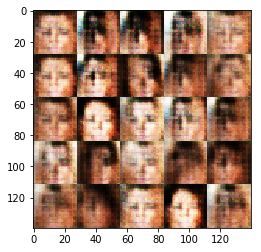

Epoch 1/2... Discriminator Loss: 0.6042... Generator Loss: 1.7598
Epoch 1/2... Discriminator Loss: 0.5598... Generator Loss: 1.7267
Epoch 1/2... Discriminator Loss: 0.5564... Generator Loss: 1.5445
Epoch 1/2... Discriminator Loss: 0.7752... Generator Loss: 1.2579
Epoch 1/2... Discriminator Loss: 0.5908... Generator Loss: 1.0813
Epoch 1/2... Discriminator Loss: 0.6869... Generator Loss: 1.6444
Epoch 1/2... Discriminator Loss: 0.5693... Generator Loss: 1.1450
Epoch 1/2... Discriminator Loss: 0.7549... Generator Loss: 2.6807
Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 0.7516
Epoch 1/2... Discriminator Loss: 0.8012... Generator Loss: 0.8446
Epoch 1/2... Discriminator Loss: 0.5475... Generator Loss: 1.4167
Epoch 1/2... Discriminator Loss: 0.7975... Generator Loss: 0.8729
Epoch 1/2... Discriminator Loss: 1.5016... Generator Loss: 6.0117
Epoch 1/2... Discriminator Loss: 0.5670... Generator Loss: 1.2067
Epoch 1/2... Discriminator Loss: 0.4868... Generator Loss: 1.6196
Epoch 1/2.

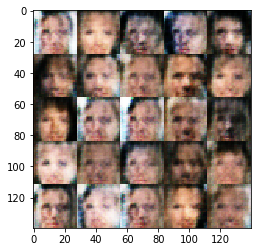

Epoch 1/2... Discriminator Loss: 0.6325... Generator Loss: 1.2334
Epoch 1/2... Discriminator Loss: 0.5868... Generator Loss: 3.0492
Epoch 1/2... Discriminator Loss: 0.3608... Generator Loss: 2.5813
Epoch 1/2... Discriminator Loss: 0.5960... Generator Loss: 2.6687
Epoch 1/2... Discriminator Loss: 1.8344... Generator Loss: 0.2412
Epoch 1/2... Discriminator Loss: 0.5603... Generator Loss: 1.4713
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 0.9341
Epoch 1/2... Discriminator Loss: 0.7238... Generator Loss: 1.1862
Epoch 1/2... Discriminator Loss: 0.6139... Generator Loss: 1.3881
Epoch 1/2... Discriminator Loss: 0.5195... Generator Loss: 1.4869
Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 0.7340
Epoch 1/2... Discriminator Loss: 0.7179... Generator Loss: 1.7155
Epoch 1/2... Discriminator Loss: 0.6652... Generator Loss: 1.1301
Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 2.8361
Epoch 1/2... Discriminator Loss: 0.9051... Generator Loss: 1.0744
Epoch 1/2.

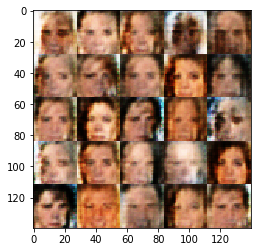

Epoch 1/2... Discriminator Loss: 0.7650... Generator Loss: 1.1014
Epoch 1/2... Discriminator Loss: 0.5921... Generator Loss: 1.7420
Epoch 1/2... Discriminator Loss: 0.8502... Generator Loss: 3.0251
Epoch 1/2... Discriminator Loss: 0.7179... Generator Loss: 1.7852
Epoch 1/2... Discriminator Loss: 0.9823... Generator Loss: 1.9099
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.4996
Epoch 1/2... Discriminator Loss: 0.5036... Generator Loss: 1.4172
Epoch 1/2... Discriminator Loss: 0.9151... Generator Loss: 1.9644
Epoch 1/2... Discriminator Loss: 0.7043... Generator Loss: 1.3098
Epoch 1/2... Discriminator Loss: 0.6104... Generator Loss: 1.5123
Epoch 1/2... Discriminator Loss: 0.9921... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 1.2262... Generator Loss: 2.4953
Epoch 1/2... Discriminator Loss: 0.5874... Generator Loss: 3.0111
Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 1.6236
Epoch 1/2... Discriminator Loss: 0.7411... Generator Loss: 2.3353
Epoch 1/2.

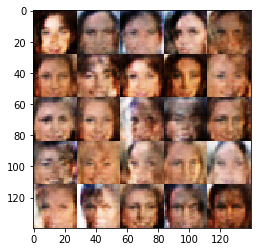

Epoch 1/2... Discriminator Loss: 0.4995... Generator Loss: 1.9740
Epoch 1/2... Discriminator Loss: 0.4227... Generator Loss: 1.7927
Epoch 1/2... Discriminator Loss: 0.8195... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.8985
Epoch 1/2... Discriminator Loss: 0.3860... Generator Loss: 2.5640
Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 0.9802
Epoch 1/2... Discriminator Loss: 0.5856... Generator Loss: 1.3404
Epoch 1/2... Discriminator Loss: 0.5235... Generator Loss: 1.7820
Epoch 1/2... Discriminator Loss: 0.4946... Generator Loss: 1.6102
Epoch 1/2... Discriminator Loss: 0.9919... Generator Loss: 0.6359
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 2.6054
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 0.4204
Epoch 1/2... Discriminator Loss: 0.6643... Generator Loss: 1.7878
Epoch 1/2... Discriminator Loss: 0.4272... Generator Loss: 2.0157
Epoch 1/2... Discriminator Loss: 0.7512... Generator Loss: 1.5086
Epoch 1/2.

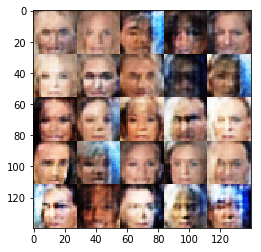

Epoch 1/2... Discriminator Loss: 0.5674... Generator Loss: 1.7949
Epoch 1/2... Discriminator Loss: 1.2602... Generator Loss: 0.4995
Epoch 1/2... Discriminator Loss: 0.5492... Generator Loss: 1.4134
Epoch 1/2... Discriminator Loss: 0.8219... Generator Loss: 1.8414
Epoch 1/2... Discriminator Loss: 0.4421... Generator Loss: 2.3024
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 0.7765... Generator Loss: 1.2724
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 0.4784
Epoch 1/2... Discriminator Loss: 1.2717... Generator Loss: 0.4721
Epoch 1/2... Discriminator Loss: 0.8282... Generator Loss: 1.0607
Epoch 1/2... Discriminator Loss: 0.5844... Generator Loss: 1.4392
Epoch 1/2... Discriminator Loss: 0.4969... Generator Loss: 1.4802
Epoch 1/2... Discriminator Loss: 0.3406... Generator Loss: 2.1041
Epoch 1/2... Discriminator Loss: 0.7819... Generator Loss: 1.2171
Epoch 1/2... Discriminator Loss: 0.8636... Generator Loss: 2.2616
Epoch 1/2.

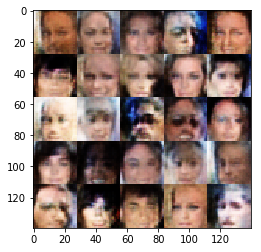

Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 2.5259
Epoch 1/2... Discriminator Loss: 0.5091... Generator Loss: 1.6326
Epoch 1/2... Discriminator Loss: 0.9315... Generator Loss: 1.5839
Epoch 1/2... Discriminator Loss: 0.5176... Generator Loss: 1.6157
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 0.6998
Epoch 1/2... Discriminator Loss: 0.4239... Generator Loss: 2.7956
Epoch 1/2... Discriminator Loss: 0.4731... Generator Loss: 2.5470
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 1.7895
Epoch 1/2... Discriminator Loss: 0.8001... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 0.7699... Generator Loss: 1.4118
Epoch 1/2... Discriminator Loss: 0.8847... Generator Loss: 1.0726
Epoch 1/2... Discriminator Loss: 0.4342... Generator Loss: 1.7269
Epoch 1/2... Discriminator Loss: 1.2460... Generator Loss: 0.4534
Epoch 1/2... Discriminator Loss: 0.7825... Generator Loss: 0.8992
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 0.5538
Epoch 1/2.

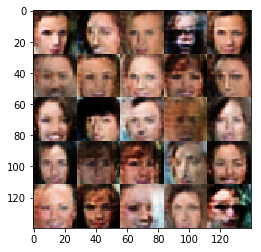

Epoch 1/2... Discriminator Loss: 0.9867... Generator Loss: 1.3498
Epoch 1/2... Discriminator Loss: 0.4289... Generator Loss: 1.5481
Epoch 1/2... Discriminator Loss: 0.8763... Generator Loss: 2.0865
Epoch 1/2... Discriminator Loss: 0.4776... Generator Loss: 1.5734
Epoch 1/2... Discriminator Loss: 0.7293... Generator Loss: 1.8131
Epoch 1/2... Discriminator Loss: 0.7214... Generator Loss: 2.1135
Epoch 1/2... Discriminator Loss: 0.5995... Generator Loss: 1.7980
Epoch 1/2... Discriminator Loss: 0.6324... Generator Loss: 2.1031
Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 0.5566... Generator Loss: 1.3989
Epoch 1/2... Discriminator Loss: 0.8431... Generator Loss: 1.4739
Epoch 1/2... Discriminator Loss: 1.4993... Generator Loss: 0.3594
Epoch 1/2... Discriminator Loss: 0.7169... Generator Loss: 1.5039
Epoch 1/2... Discriminator Loss: 0.6534... Generator Loss: 1.2451
Epoch 1/2... Discriminator Loss: 1.1783... Generator Loss: 0.5429
Epoch 1/2.

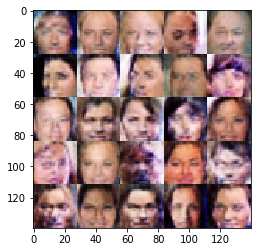

Epoch 1/2... Discriminator Loss: 0.6655... Generator Loss: 1.1601
Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 1.9537
Epoch 1/2... Discriminator Loss: 0.6268... Generator Loss: 1.4453
Epoch 1/2... Discriminator Loss: 0.6009... Generator Loss: 1.7454
Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 0.9475
Epoch 1/2... Discriminator Loss: 0.7191... Generator Loss: 1.0406
Epoch 1/2... Discriminator Loss: 0.7127... Generator Loss: 1.4765
Epoch 1/2... Discriminator Loss: 0.9140... Generator Loss: 2.4093
Epoch 1/2... Discriminator Loss: 0.7710... Generator Loss: 1.1043
Epoch 1/2... Discriminator Loss: 0.7521... Generator Loss: 1.0286
Epoch 1/2... Discriminator Loss: 0.6971... Generator Loss: 1.0598
Epoch 1/2... Discriminator Loss: 0.3628... Generator Loss: 2.0395
Epoch 1/2... Discriminator Loss: 0.7489... Generator Loss: 1.3014
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 0.5367
Epoch 1/2... Discriminator Loss: 0.7175... Generator Loss: 1.7850
Epoch 1/2.

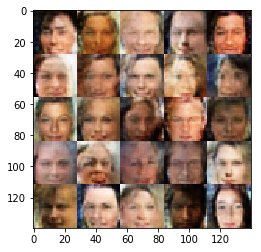

Epoch 1/2... Discriminator Loss: 0.7474... Generator Loss: 1.2183
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.5130
Epoch 1/2... Discriminator Loss: 0.7383... Generator Loss: 1.2023
Epoch 1/2... Discriminator Loss: 0.8001... Generator Loss: 0.9478
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 1.8390
Epoch 1/2... Discriminator Loss: 0.9096... Generator Loss: 1.2961
Epoch 1/2... Discriminator Loss: 0.5280... Generator Loss: 1.4352
Epoch 1/2... Discriminator Loss: 0.4745... Generator Loss: 1.9757
Epoch 1/2... Discriminator Loss: 1.8033... Generator Loss: 0.2680
Epoch 1/2... Discriminator Loss: 0.8550... Generator Loss: 0.9099
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 0.5988
Epoch 1/2... Discriminator Loss: 0.7869... Generator Loss: 1.4933
Epoch 1/2... Discriminator Loss: 0.8939... Generator Loss: 0.8022
Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 1.1061
Epoch 1/2... Discriminator Loss: 0.2703... Generator Loss: 2.4800
Epoch 1/2.

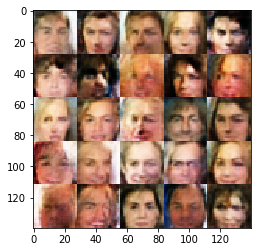

Epoch 1/2... Discriminator Loss: 0.5227... Generator Loss: 1.5988
Epoch 1/2... Discriminator Loss: 0.6482... Generator Loss: 1.4445
Epoch 1/2... Discriminator Loss: 0.6979... Generator Loss: 1.1156
Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 0.5672... Generator Loss: 1.8156
Epoch 1/2... Discriminator Loss: 0.4863... Generator Loss: 1.5331
Epoch 1/2... Discriminator Loss: 1.1543... Generator Loss: 0.9962
Epoch 1/2... Discriminator Loss: 0.6335... Generator Loss: 1.0464
Epoch 1/2... Discriminator Loss: 1.0093... Generator Loss: 2.7755
Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 0.6837
Epoch 1/2... Discriminator Loss: 0.4525... Generator Loss: 2.4150
Epoch 1/2... Discriminator Loss: 0.9374... Generator Loss: 0.9134
Epoch 1/2... Discriminator Loss: 0.6502... Generator Loss: 1.6027
Epoch 1/2... Discriminator Loss: 0.8133... Generator Loss: 1.1237
Epoch 1/2... Discriminator Loss: 1.2389... Generator Loss: 2.3702
Epoch 1/2.

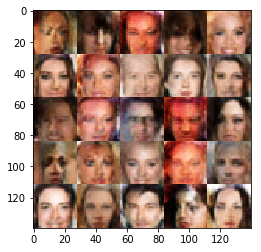

Epoch 1/2... Discriminator Loss: 0.6164... Generator Loss: 1.4555
Epoch 1/2... Discriminator Loss: 0.8509... Generator Loss: 0.8770
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 0.5701
Epoch 1/2... Discriminator Loss: 0.8278... Generator Loss: 0.9456
Epoch 1/2... Discriminator Loss: 0.6278... Generator Loss: 1.5032
Epoch 1/2... Discriminator Loss: 0.7508... Generator Loss: 0.9239
Epoch 1/2... Discriminator Loss: 0.6740... Generator Loss: 0.9724
Epoch 1/2... Discriminator Loss: 0.9766... Generator Loss: 0.7009
Epoch 1/2... Discriminator Loss: 0.8719... Generator Loss: 0.9282
Epoch 1/2... Discriminator Loss: 0.9003... Generator Loss: 0.8008
Epoch 1/2... Discriminator Loss: 0.7478... Generator Loss: 1.5513
Epoch 1/2... Discriminator Loss: 0.4453... Generator Loss: 2.0575
Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 0.5815
Epoch 1/2... Discriminator Loss: 0.7015... Generator Loss: 1.4942
Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 0.5602
Epoch 1/2.

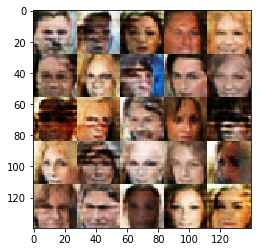

Epoch 1/2... Discriminator Loss: 0.6431... Generator Loss: 1.5416
Epoch 1/2... Discriminator Loss: 0.4592... Generator Loss: 1.9880
Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 1.0332
Epoch 1/2... Discriminator Loss: 0.5878... Generator Loss: 1.6568
Epoch 1/2... Discriminator Loss: 0.6906... Generator Loss: 1.3187
Epoch 1/2... Discriminator Loss: 0.8206... Generator Loss: 0.8864
Epoch 1/2... Discriminator Loss: 0.9938... Generator Loss: 1.6332
Epoch 1/2... Discriminator Loss: 0.7857... Generator Loss: 1.3857
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 0.9059
Epoch 1/2... Discriminator Loss: 0.6091... Generator Loss: 1.4380
Epoch 1/2... Discriminator Loss: 0.7804... Generator Loss: 1.0954
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 0.9940
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 0.8755
Epoch 1/2... Discriminator Loss: 0.8647... Generator Loss: 1.3895
Epoch 1/2... Discriminator Loss: 1.5161... Generator Loss: 0.3522
Epoch 1/2.

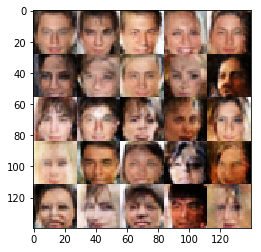

Epoch 1/2... Discriminator Loss: 0.8001... Generator Loss: 1.0548
Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 1.8088
Epoch 1/2... Discriminator Loss: 0.5381... Generator Loss: 1.5969
Epoch 1/2... Discriminator Loss: 0.9703... Generator Loss: 0.6644
Epoch 1/2... Discriminator Loss: 0.7720... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 0.6516... Generator Loss: 1.1919
Epoch 1/2... Discriminator Loss: 0.7237... Generator Loss: 1.1777
Epoch 1/2... Discriminator Loss: 1.4377... Generator Loss: 0.3260
Epoch 1/2... Discriminator Loss: 0.8099... Generator Loss: 0.8578
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 0.6813
Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 0.4075... Generator Loss: 1.7355
Epoch 1/2... Discriminator Loss: 0.5062... Generator Loss: 1.2869
Epoch 1/2... Discriminator Loss: 0.5403... Generator Loss: 1.5606
Epoch 1/2... Discriminator Loss: 1.3439... Generator Loss: 0.3846
Epoch 1/2.

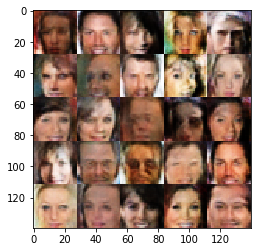

Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.4496
Epoch 2/2... Discriminator Loss: 0.7945... Generator Loss: 1.0132
Epoch 2/2... Discriminator Loss: 0.7959... Generator Loss: 1.4062
Epoch 2/2... Discriminator Loss: 0.7567... Generator Loss: 2.3284


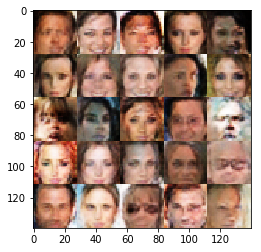

Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 1.8158
Epoch 2/2... Discriminator Loss: 1.0523... Generator Loss: 0.7268
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 0.8173
Epoch 2/2... Discriminator Loss: 0.9487... Generator Loss: 0.7192
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 1.2186
Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 0.7464
Epoch 2/2... Discriminator Loss: 0.6200... Generator Loss: 1.6935
Epoch 2/2... Discriminator Loss: 0.7444... Generator Loss: 1.2824
Epoch 2/2... Discriminator Loss: 0.6665... Generator Loss: 1.0576
Epoch 2/2... Discriminator Loss: 0.8070... Generator Loss: 1.8448
Epoch 2/2... Discriminator Loss: 0.8616... Generator Loss: 0.9313
Epoch 2/2... Discriminator Loss: 0.6221... Generator Loss: 1.1020
Epoch 2/2... Discriminator Loss: 0.4812... Generator Loss: 1.5490
Epoch 2/2... Discriminator Loss: 1.1242... Generator Loss: 0.5507
Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 1.0953
Epoch 2/2.

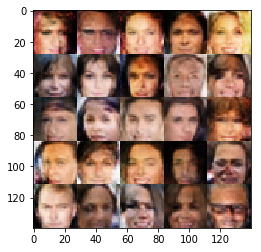

Epoch 2/2... Discriminator Loss: 1.1913... Generator Loss: 0.4950
Epoch 2/2... Discriminator Loss: 0.5512... Generator Loss: 1.6514
Epoch 2/2... Discriminator Loss: 1.1591... Generator Loss: 0.5833
Epoch 2/2... Discriminator Loss: 0.5199... Generator Loss: 1.7619
Epoch 2/2... Discriminator Loss: 0.5587... Generator Loss: 1.6326
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 1.3352
Epoch 2/2... Discriminator Loss: 0.7194... Generator Loss: 1.3104
Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 0.5049
Epoch 2/2... Discriminator Loss: 0.6152... Generator Loss: 1.1617
Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 0.5634
Epoch 2/2... Discriminator Loss: 0.9414... Generator Loss: 1.5018
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 0.8122
Epoch 2/2... Discriminator Loss: 1.0368... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 0.6184... Generator Loss: 1.1761
Epoch 2/2... Discriminator Loss: 1.2095... Generator Loss: 0.5430
Epoch 2/2.

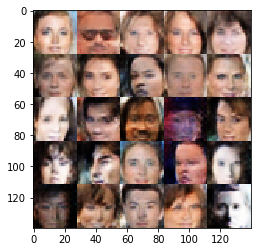

Epoch 2/2... Discriminator Loss: 0.5948... Generator Loss: 1.4680
Epoch 2/2... Discriminator Loss: 0.7314... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 0.8912
Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 0.8945
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 0.6936
Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 0.7711
Epoch 2/2... Discriminator Loss: 0.5856... Generator Loss: 1.1791
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 0.5536
Epoch 2/2... Discriminator Loss: 0.7579... Generator Loss: 1.3979
Epoch 2/2... Discriminator Loss: 0.6688... Generator Loss: 1.3085
Epoch 2/2... Discriminator Loss: 0.7390... Generator Loss: 1.0883
Epoch 2/2... Discriminator Loss: 0.5691... Generator Loss: 1.5153
Epoch 2/2... Discriminator Loss: 0.7244... Generator Loss: 1.2639
Epoch 2/2... Discriminator Loss: 1.1024... Generator Loss: 0.5141
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 0.5885
Epoch 2/2.

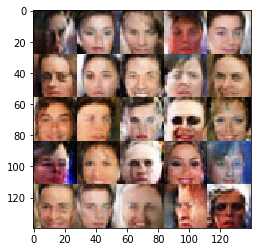

Epoch 2/2... Discriminator Loss: 1.0337... Generator Loss: 1.0501
Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 0.6078
Epoch 2/2... Discriminator Loss: 1.5536... Generator Loss: 0.2820
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 1.0121
Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 1.1558
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 0.6146
Epoch 2/2... Discriminator Loss: 0.6127... Generator Loss: 1.3204
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 0.7047
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 0.8708
Epoch 2/2... Discriminator Loss: 0.8977... Generator Loss: 0.9435
Epoch 2/2... Discriminator Loss: 0.7046... Generator Loss: 1.0974
Epoch 2/2... Discriminator Loss: 0.9395... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 0.6389... Generator Loss: 1.3525
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 1.2633
Epoch 2/2... Discriminator Loss: 0.6574... Generator Loss: 1.2166
Epoch 2/2.

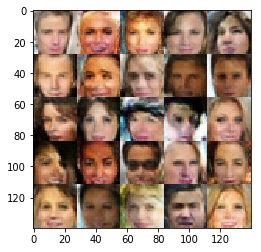

Epoch 2/2... Discriminator Loss: 0.8524... Generator Loss: 0.8735
Epoch 2/2... Discriminator Loss: 1.1489... Generator Loss: 0.5253
Epoch 2/2... Discriminator Loss: 1.1941... Generator Loss: 0.5740
Epoch 2/2... Discriminator Loss: 0.7200... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 0.9390... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 1.1577
Epoch 2/2... Discriminator Loss: 0.9608... Generator Loss: 0.6993
Epoch 2/2... Discriminator Loss: 1.3074... Generator Loss: 0.4538
Epoch 2/2... Discriminator Loss: 0.6899... Generator Loss: 1.0760
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 0.5588
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 0.5421
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 0.7939
Epoch 2/2... Discriminator Loss: 0.9978... Generator Loss: 1.5761
Epoch 2/2... Discriminator Loss: 0.7565... Generator Loss: 1.0177
Epoch 2/2... Discriminator Loss: 1.1125... Generator Loss: 0.5915
Epoch 2/2.

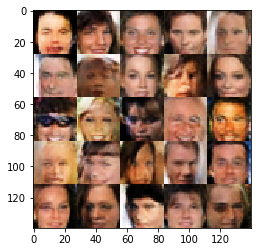

Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 0.6178
Epoch 2/2... Discriminator Loss: 0.9193... Generator Loss: 0.7877
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 0.7990... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 0.3295... Generator Loss: 2.0214
Epoch 2/2... Discriminator Loss: 0.6212... Generator Loss: 1.1159
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 2.4123
Epoch 2/2... Discriminator Loss: 1.0240... Generator Loss: 0.7051
Epoch 2/2... Discriminator Loss: 0.7459... Generator Loss: 0.9146
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 0.9046
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 0.5531
Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 0.9794
Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 1.0180
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 0.7594
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 0.5804
Epoch 2/2.

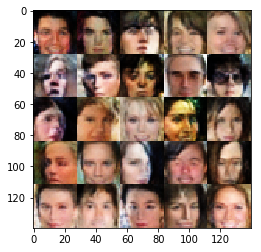

Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 0.9502
Epoch 2/2... Discriminator Loss: 1.1603... Generator Loss: 0.5352
Epoch 2/2... Discriminator Loss: 0.7789... Generator Loss: 1.0687
Epoch 2/2... Discriminator Loss: 0.7269... Generator Loss: 1.1596
Epoch 2/2... Discriminator Loss: 0.8663... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 0.5013... Generator Loss: 1.6545
Epoch 2/2... Discriminator Loss: 0.5345... Generator Loss: 1.7147
Epoch 2/2... Discriminator Loss: 1.0331... Generator Loss: 0.6524
Epoch 2/2... Discriminator Loss: 0.4584... Generator Loss: 1.8639
Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 0.4552
Epoch 2/2... Discriminator Loss: 1.0393... Generator Loss: 1.0654
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 1.3843
Epoch 2/2... Discriminator Loss: 0.8766... Generator Loss: 1.1558
Epoch 2/2... Discriminator Loss: 1.6067... Generator Loss: 0.3864
Epoch 2/2... Discriminator Loss: 0.5533... Generator Loss: 1.3880
Epoch 2/2.

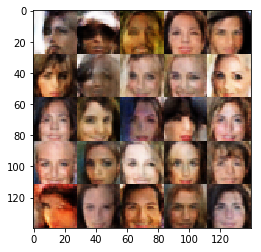

Epoch 2/2... Discriminator Loss: 0.8489... Generator Loss: 0.9294
Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 0.9838
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.4667
Epoch 2/2... Discriminator Loss: 0.7375... Generator Loss: 1.0046
Epoch 2/2... Discriminator Loss: 1.0157... Generator Loss: 0.8415
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 0.6310
Epoch 2/2... Discriminator Loss: 1.0459... Generator Loss: 0.7690
Epoch 2/2... Discriminator Loss: 0.6331... Generator Loss: 1.0472
Epoch 2/2... Discriminator Loss: 0.9352... Generator Loss: 0.7397
Epoch 2/2... Discriminator Loss: 0.5089... Generator Loss: 1.4077
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 0.9016
Epoch 2/2... Discriminator Loss: 1.7944... Generator Loss: 0.2397
Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 0.7070
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.6628
Epoch 2/2... Discriminator Loss: 0.8837... Generator Loss: 1.0578
Epoch 2/2.

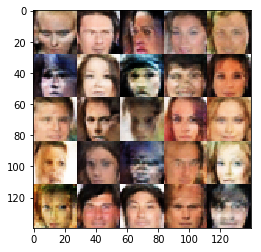

Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 0.7117
Epoch 2/2... Discriminator Loss: 1.6727... Generator Loss: 0.3436
Epoch 2/2... Discriminator Loss: 0.8045... Generator Loss: 1.0907
Epoch 2/2... Discriminator Loss: 0.8349... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 1.1207... Generator Loss: 0.6220
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 0.4831
Epoch 2/2... Discriminator Loss: 0.6764... Generator Loss: 1.2305
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 0.7039
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.3926
Epoch 2/2... Discriminator Loss: 1.1111... Generator Loss: 0.5823
Epoch 2/2... Discriminator Loss: 0.9654... Generator Loss: 1.1683
Epoch 2/2... Discriminator Loss: 0.7049... Generator Loss: 1.3922
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 0.9078
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 0.9587
Epoch 2/2... Discriminator Loss: 1.0491... Generator Loss: 0.5838
Epoch 2/2.

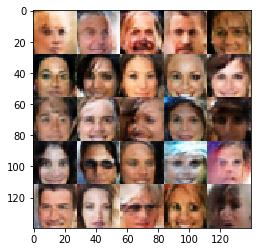

Epoch 2/2... Discriminator Loss: 1.6769... Generator Loss: 0.2935
Epoch 2/2... Discriminator Loss: 0.7875... Generator Loss: 0.7838
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 0.8757
Epoch 2/2... Discriminator Loss: 0.6871... Generator Loss: 1.3840
Epoch 2/2... Discriminator Loss: 0.8822... Generator Loss: 1.0361
Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 0.4744
Epoch 2/2... Discriminator Loss: 0.9559... Generator Loss: 0.6980
Epoch 2/2... Discriminator Loss: 1.0155... Generator Loss: 0.5857
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 0.9992
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 0.7756
Epoch 2/2... Discriminator Loss: 1.0171... Generator Loss: 0.6060
Epoch 2/2... Discriminator Loss: 0.8869... Generator Loss: 0.8054
Epoch 2/2... Discriminator Loss: 1.3810... Generator Loss: 0.4004
Epoch 2/2... Discriminator Loss: 0.7723... Generator Loss: 0.9217
Epoch 2/2... Discriminator Loss: 1.0294... Generator Loss: 0.7777
Epoch 2/2.

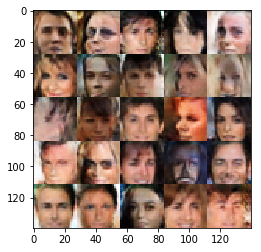

Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 0.4237
Epoch 2/2... Discriminator Loss: 0.4009... Generator Loss: 2.0956
Epoch 2/2... Discriminator Loss: 0.9029... Generator Loss: 0.8466
Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 1.0047
Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 0.6651
Epoch 2/2... Discriminator Loss: 0.8838... Generator Loss: 0.7385
Epoch 2/2... Discriminator Loss: 0.9774... Generator Loss: 0.6666
Epoch 2/2... Discriminator Loss: 0.6846... Generator Loss: 1.0102
Epoch 2/2... Discriminator Loss: 0.7876... Generator Loss: 1.3993
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 1.0357
Epoch 2/2... Discriminator Loss: 0.9733... Generator Loss: 0.7663
Epoch 2/2... Discriminator Loss: 1.1959... Generator Loss: 0.5323
Epoch 2/2... Discriminator Loss: 1.4044... Generator Loss: 0.3410
Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.1968
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 0.8795
Epoch 2/2.

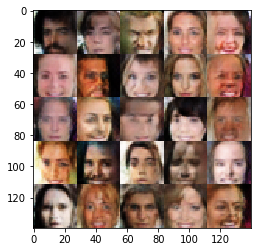

Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 0.9062
Epoch 2/2... Discriminator Loss: 0.5490... Generator Loss: 1.3946
Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 0.8825
Epoch 2/2... Discriminator Loss: 0.7412... Generator Loss: 1.1833
Epoch 2/2... Discriminator Loss: 0.7626... Generator Loss: 0.9384
Epoch 2/2... Discriminator Loss: 0.8425... Generator Loss: 1.5644
Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 0.5659
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.1182
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 0.8514
Epoch 2/2... Discriminator Loss: 1.6674... Generator Loss: 0.3044
Epoch 2/2... Discriminator Loss: 0.9832... Generator Loss: 0.6541
Epoch 2/2... Discriminator Loss: 1.4237... Generator Loss: 0.3595
Epoch 2/2... Discriminator Loss: 1.1927... Generator Loss: 0.4854
Epoch 2/2... Discriminator Loss: 0.7633... Generator Loss: 1.0941
Epoch 2/2... Discriminator Loss: 0.6388... Generator Loss: 1.3615
Epoch 2/2.

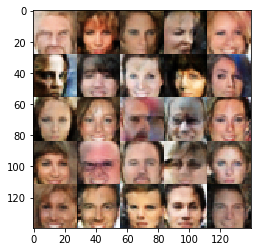

Epoch 2/2... Discriminator Loss: 1.1214... Generator Loss: 0.6834
Epoch 2/2... Discriminator Loss: 1.1949... Generator Loss: 0.5065
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 0.6449
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.9056
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 0.8058
Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 1.4085
Epoch 2/2... Discriminator Loss: 0.9651... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 1.0013... Generator Loss: 0.7604
Epoch 2/2... Discriminator Loss: 1.6453... Generator Loss: 0.2817
Epoch 2/2... Discriminator Loss: 1.0478... Generator Loss: 0.6779
Epoch 2/2... Discriminator Loss: 0.9723... Generator Loss: 0.7814
Epoch 2/2... Discriminator Loss: 0.7051... Generator Loss: 0.9280
Epoch 2/2... Discriminator Loss: 0.7487... Generator Loss: 1.1561
Epoch 2/2... Discriminator Loss: 1.1786... Generator Loss: 0.6248
Epoch 2/2... Discriminator Loss: 0.8189... Generator Loss: 0.9224
Epoch 2/2.

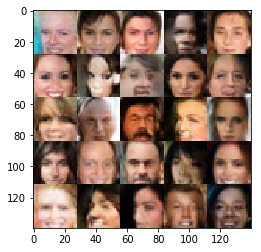

Epoch 2/2... Discriminator Loss: 0.8336... Generator Loss: 1.0214
Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 1.3257
Epoch 2/2... Discriminator Loss: 1.0238... Generator Loss: 0.9714
Epoch 2/2... Discriminator Loss: 1.2408... Generator Loss: 0.5067
Epoch 2/2... Discriminator Loss: 1.6098... Generator Loss: 0.8004
Epoch 2/2... Discriminator Loss: 0.8829... Generator Loss: 0.7518
Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.1253
Epoch 2/2... Discriminator Loss: 0.7914... Generator Loss: 0.9144
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 1.1990
Epoch 2/2... Discriminator Loss: 1.1946... Generator Loss: 0.5478
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 0.4717
Epoch 2/2... Discriminator Loss: 0.9046... Generator Loss: 0.7242
Epoch 2/2... Discriminator Loss: 0.8508... Generator Loss: 1.5516
Epoch 2/2... Discriminator Loss: 1.6405... Generator Loss: 0.4434
Epoch 2/2.

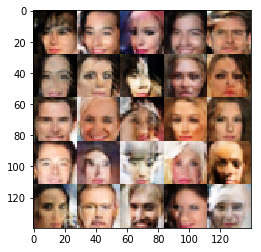

Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.4141
Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 1.2989
Epoch 2/2... Discriminator Loss: 0.9423... Generator Loss: 0.8261
Epoch 2/2... Discriminator Loss: 0.9802... Generator Loss: 0.7648
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 0.5812
Epoch 2/2... Discriminator Loss: 0.8317... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 0.5821
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 0.5734
Epoch 2/2... Discriminator Loss: 1.4518... Generator Loss: 0.4116
Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 1.1617
Epoch 2/2... Discriminator Loss: 0.8139... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 1.3375... Generator Loss: 0.5548
Epoch 2/2... Discriminator Loss: 0.9173... Generator Loss: 1.1030
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 0.7730
Epoch 2/2.

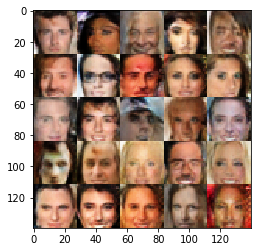

Epoch 2/2... Discriminator Loss: 0.9101... Generator Loss: 0.7913
Epoch 2/2... Discriminator Loss: 0.9181... Generator Loss: 1.4631
Epoch 2/2... Discriminator Loss: 1.0743... Generator Loss: 0.6092
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.9122
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 1.3668
Epoch 2/2... Discriminator Loss: 1.1615... Generator Loss: 1.4636
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 0.9564
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.4450
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 0.8288
Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 0.9711
Epoch 2/2... Discriminator Loss: 1.5167... Generator Loss: 0.3982
Epoch 2/2... Discriminator Loss: 1.0704... Generator Loss: 0.5995
Epoch 2/2... Discriminator Loss: 1.1651... Generator Loss: 0.6640


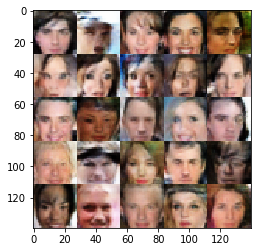

In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.